# Debietstatistieken

In [1]:
import geopandas as gpd
import hkvsobekpy as hkv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import shutil

C:\Users\hurkmans\AppData\Local\Temp\ipykernel_5804\1713456451.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# resultaten van deze cases worden samengevoegd
cases = [1,2]
# binnen deze periode worden maanden beschouwd (alleen maand en dag zijn relevant)
period = pd.date_range(start=pd.Timestamp('1900-05-15'),end=pd.Timestamp('1900-09-15'), freq='D')

# geef het aantal dagen dat het deze afvoer wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
overschrijdingsduur_van_debiet = {'name': 'Ex5-9_005',  'value': 0.05}
# geef de fractie van de tijd dat het deze afvoer wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
relatieve_overschrijdingsduur_van_debiet = {'name': 'REx5-9_005',  'value': 0.05}
# geef de afvoer die dit percentiel van de tijd wordt overschreden. De naam is de naam van de kolom waarmee deze in de shapefile verschijnt.
debiet_bij_tijdpercentiel = {'name': 'Q5-9_80%',  'value': 0.8}

## Copy files


In [3]:
# litfolder = 'MOD_DEF_V4.lit'
# for case in range(1,13):
#     wrkpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'work'
#     if wrkpath.exists():
#         srcpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'work' / 'reachseg.his'
#     else:
#         srcpath = Path(r'R:\pr\4569_20\SOBEK216') / litfolder / str(case) / 'reachseg.his'
#     tarpath = Path(r'D:\4569.20\testout_sobek') / litfolder / str(case)
#     tarpath.mkdir(parents=True, exist_ok=True)
#     shutil.copy2(srcpath, tarpath)

### Read shapefile from  Sobek export

<Axes: >

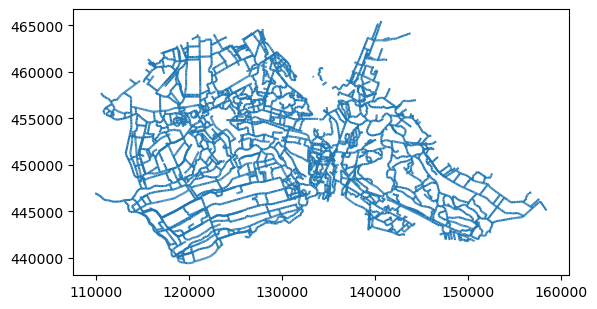

In [4]:
pad_to_export = Path(r'D:\4569.20\testout_sobek')
seg_shape = gpd.read_file(str(pad_to_export / 'RchSegments.shp'))
seg_shape.columns = [col.strip() for col in seg_shape.columns]
seg_shape.index = seg_shape['ID']
seg_shape.drop(['NAME', "TYPE", 'PARENTID', 'ID_FROM', 'ID_TO', 'USERID'], axis=1, inplace=True)
seg_shape.plot()

### Read hisfiles from sobek

In [5]:
pad_to_sobek = Path(r'D:\4569.20\testout_sobek\MOD_ADJ_V4.lit')
# pad_to_sobek = Path(r'R:\pr\4569_20\SOBEK216\MOD_ADJ_V4.lit')
cases = [1,2,3,4,5,6,7,8,9,10,11,12]

In [6]:
subhislist = []
for case in cases:    
    pad_to_his = str(pad_to_sobek / str(case) / 'reachseg.his')
#     pad_to_his = str(pad_to_sobek / 'reachseg.his')
    reachseg = hkv.read_his.ReadMetadata(pad_to_his)    
    # struc = hkv.read_his.ReadMetadata(str(pad_to_his / 'struc.his'))
    reach_segments = reachseg.DataFrame()
    reach_segments = reach_segments.iloc[32:,:]
    locs= reachseg.GetLocations()
    params= reachseg.GetParameters()
    reach_segments = reach_segments.loc[:,params[params.index('Discharge mean(m³/s)')]]
    reach_segments.head()
    subhislist.append(reach_segments)
all_data = pd.concat(subhislist)
all_data['MONTH'] = all_data.index.month

In [10]:
# functie om statistieken toe te voegen aan de shapefile
def overschrijdingsduur(x=None, threshold=None):
    return(len(x[x > threshold]))
def relatieve_overschrijdingsduur(x=None, threshold=None):
    return(len(x[x > threshold])/len(x))

def add_statistic(output, data, stype,overschrijdingsduur_van_debiet=None, relatieve_overschrijdingsduur_van_debiet=None,debiet_bij_tijdpercentiel=None, name=None):
    if stype=='gemiddelde':
        statcol = data.mean(axis=0)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='standaard_afwijking':
        statcol = data.std(axis=0)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='variantie':
        statcol = data.std(axis=0)**2
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    elif stype=='overschrijdingsduur':
        statcol = data.apply(overschrijdingsduur, axis=0, threshold=overschrijdingsduur_van_debiet)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)          
    elif stype=='relatieve_overschrijdingsduur':
        statcol = data.apply(relatieve_overschrijdingsduur, axis=0, threshold=relatieve_overschrijdingsduur_van_debiet)
        statcol.name = name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)          
    elif stype=='percentiel':
        statcol = data.quantile(debiet_bij_tijdpercentiel)
        statcol.name=name
        output = pd.concat([output, statcol],axis=1, join="inner",ignore_index=False,copy=True)        
    else:
        print('Onbekend statistiektype. Kies uit: gemiddelde, standaard_afwijking, variantie, overschrijdingsduur, relatieve_overschrijdingsduur, percentiel')
    return(output)

Voeg kolommen toe met statistiek

In [11]:
sub_data = all_data[all_data.index.strftime('%m%d').isin(period.strftime('%m%d'))]
output = add_statistic(seg_shape, sub_data, 'gemiddelde', name='Av')
output = add_statistic(output, sub_data, 'variantie', name='Var')
if overschrijdingsduur_van_debiet is not None:
    output = add_statistic(output, sub_data, 'overschrijdingsduur', name=overschrijdingsduur_van_debiet['name'], overschrijdingsduur_van_debiet=overschrijdingsduur_van_debiet['value'])
if relatieve_overschrijdingsduur_van_debiet is not None:
    output = add_statistic(output, sub_data, 'relatieve_overschrijdingsduur', name=relatieve_overschrijdingsduur_van_debiet['name'], relatieve_overschrijdingsduur_van_debiet=relatieve_overschrijdingsduur_van_debiet['value'])
if debiet_bij_tijdpercentiel is not None:
    output = add_statistic(output, sub_data, 'percentiel', name=debiet_bij_tijdpercentiel['name'], debiet_bij_tijdpercentiel=debiet_bij_tijdpercentiel['value'])


Schrijf het resultaat naar een shapefile

In [12]:
output.to_file(str(pad_to_export /  'debietstatistieken.shp'))